C:\Users\David\AppData\Roaming\Python\Python312\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:542: ComplexWarning: Casting complex values to real discards the imaginary part
  self._arpack_solver(self.ido, self.bmat, self.which, self.k,


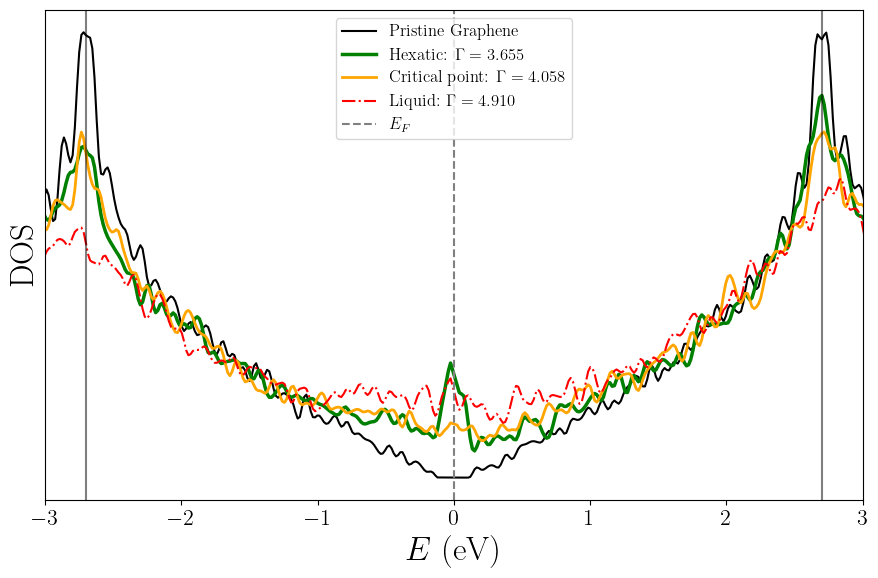

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.sparse import lil_matrix
import kwant.kpm as kpm
from kwant.kpm import jackson_kernel
from scipy.ndimage import gaussian_filter1d

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    # optionally make all font sizes a bit larger for publication
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 12,
})

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

a = 1.42

# ---- Parameters: list your systems here ----
systems = [
    {
        "label": "Pristine Graphene",
        "coord_file": "../LAMMPS/graphene.dat",
        "cutoff": 1.2*a,
        "onsite_noise": 0.01,    # no noise for pristine
        "interp_cut": 0.1,     # window (eV) to remove spike
        "color": "k",
        "linestyle": "-",
        "gauss_sigma": None,     # no extra smoothing
        "lw": 1.5
    },
    {
        "label": r"Hexatic: $\Gamma = 3.655$",
        "coord_file": "../output/GAMMAS/9750/anneal_9750K.data",
        "cutoff": 1.2*a,
        "onsite_noise": 0.1,   # small noise to lift zero modes
        "interp_cut": 0.01,     # wider window for MAC
        "color": "green",
        "linestyle": "-",
        "gauss_sigma": None,     # apply Gaussian smoothing
        "lw": 2.5   
    },
    {
        "label": r"Critical point: $\Gamma = 4.058$",
        "coord_file": "../output/GAMMAS/9900/min_9900K.data",
        "cutoff": 1.2*a,
        "onsite_noise": 0.1,   # small noise to lift zero modes
        "interp_cut": 0.01,     # wider window for MAC
        "color": "orange",
        "linestyle": "-",
        "gauss_sigma": None,     # apply Gaussian smoothing
        "lw": 2
    },
    {
        "label": r"Liquid: $\Gamma = 4.910$",
        "coord_file": "../output/GAMMAS/10350/anneal_10350K.data",
        "cutoff": 1.2*a,
        "onsite_noise": 0.1,   # small noise to lift zero modes
        "interp_cut": 0.01,     # wider window for MAC
        "color": "red",
        "linestyle": "dashdot",
        "gauss_sigma": None,     # apply Gaussian smoothing
        "lw": 1.5
    }
]


def read_coords(fname):
    """Skip header and read x,y columns (cols 2,3)."""
    return np.loadtxt(fname, skiprows=15)[:, 2:4]

def build_tb_hamiltonian(pts, t=2.7, cutoff=1.2*1.42, onsite_noise=0.0):
    """Nearest-neighbor TB + optional small onsite disorder."""
    N    = len(pts)
    tree = cKDTree(pts)
    pairs = tree.query_pairs(r=cutoff)
    H = lil_matrix((N, N), dtype=float)
    # hoppings
    for i, j in pairs:
        H[i, j] = t
        H[j, i] = t
    # onsite noise
    if onsite_noise > 0:
        rng = np.random.default_rng(42)
        H.setdiag(rng.normal(scale=onsite_noise, size=N))
    return H.tocsr()

def compute_dos_kpm(H, E, num_moments=1000, num_vectors=10):
    """Compute DOS(E) via KPM with Jackson kernel."""
    sd = kpm.SpectralDensity(H,
                              num_moments=num_moments,
                              num_vectors=num_vectors,
                              kernel=jackson_kernel)
    return sd(E).real

def remove_spike(E, dos, cut):
    """Interpolate away any |E|<cut region to kill delta-spike."""
    mask = np.abs(E) < cut
    dos[mask] = np.interp(E[mask], E[~mask], dos[~mask])
    return dos


E = np.linspace(-4, 4, 500)

results = []

for sys_def in systems:
    pts = read_coords(sys_def["coord_file"])
    H   = build_tb_hamiltonian(
        pts,
        cutoff=sys_def["cutoff"],
        onsite_noise=sys_def["onsite_noise"]
    )
    dos = compute_dos_kpm(H, E)
    dos = remove_spike(E, dos, sys_def["interp_cut"])
    # optional Gaussian smoothing
    if sys_def["gauss_sigma"]:
        dos = gaussian_filter1d(dos, sigma=sys_def["gauss_sigma"])
    results.append((sys_def["label"], E, dos, sys_def))

plt.figure(figsize=(9,6))
for label, E, dos, cfg in results:
    plt.plot(E, dos,
             label=label,
             color=cfg["color"],
             linestyle=cfg["linestyle"],
             lw=cfg["lw"])

plt.axvline(0, linestyle='--', label=r"$E_F$", c="gray")
plt.xlabel(r"$E$ (eV)", fontsize=24)
plt.ylabel("DOS", fontsize=24)
plt.xlim(-3, 3)
plt.yticks([])
plt.axvline(-2.7, c='k', alpha=0.5)
plt.axvline(2.7, c = 'k', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("DOS.png", dpi=200)
plt.show()


In [ ]:
#!/usr/bin/env python3

from __future__ import print_function
from pythtb import *            # tight‑binding library
import numpy as np
import matplotlib.pyplot as plt

lat = [[1.0, 0.0],              # a1
       [0.5, np.sqrt(3.)/2]]    # a2


orb = [[1./3, 1./3],  # 0  A‑pz
       [1./3, 1./3],  # 1  A‑px
       [1./3, 1./3],  # 2  A‑py
       [2./3, 2./3],  # 3  B‑pz
       [2./3, 2./3],  # 4  B‑px
       [2./3, 2./3]]  # 5  B‑py

model = tb_model(2, 2, lat, orb)

# on‑site energies (eV)
#   π‑orbitals (pz) at 0 eV, σ‑orbitals (px,py) 3 eV higher
model.set_onsite([0.0, 3.0, 3.0,
                  0.0, 3.0, 3.0])

# nearest‑neighbour hoppings (eV)
t_pi, t_sigma = -2.77, -1.0
pairs = [(0, 3, t_pi),      # pz  A↔B
         (1, 4, t_sigma),   # px  A↔B
         (2, 5, t_sigma)]   # py  A↔B

# apply to the three equivalent neighbours of honeycomb lattice
for ia, ib, t in pairs:
    model.set_hop(t, ia, ib, [ 0, 0])
    model.set_hop(t, ib, ia, [ 1, 0])
    model.set_hop(t, ib, ia, [ 0, 1])

# ----------------------------------------------------------------------
# high‑symmetry line  Γ → K → M → Γ   (conventional for 2‑D graphene)
path   = [[0.0, 0.0],          # Γ
          [2./3, 1./3],        # K
          [0.5, 0.5],          # M
          [0.0, 0.0]]          # Γ
labels = (r"$\Gamma$", r"$K$", r"$M$", r"$\Gamma$")
nk = 121                       # points between each node

k_vec, k_dist, k_node = model.k_path(path, nk)
evals = model.solve_all(k_vec)     # shape (6, nk)

# ----------------------------------------------------------------------
# plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(k_node[0], k_node[-1])
ax.set_xticks(k_node)
ax.set_xticklabels(labels)
for kn in k_node:
    ax.axvline(x=kn, linewidth=0.5, color="k")

ax.set_xlabel("Wave vector")
ax.set_ylabel("Energy (eV)")

for n in range(model._norb):       # _norb = 6 → draw every band
    ax.plot(k_dist, evals[n], c="k")

fig.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'pythtb'

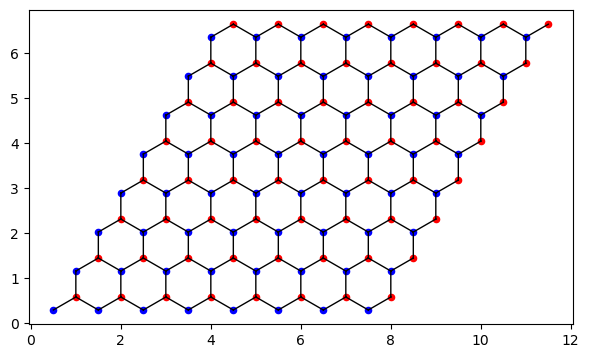

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 2‑D graphene lattice data
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, np.sqrt(3) / 2])

basis = np.array([
    [1/3, 1/3],   # A site
    [2/3, 2/3]    # B site
])


Nx, Ny = 8, 8                      # unit‑cells in each direction
cartesian_positions = []
sublattice = []

for i in range(Nx):
    for j in range(Ny):
        R = i * a1 + j * a2
        for s, frac in enumerate(basis):
            cartesian_positions.append(R + frac[0] * a1 + frac[1] * a2)
            sublattice.append(s)

cartesian_positions = np.array(cartesian_positions)
sublattice = np.array(sublattice)

from scipy.spatial import distance_matrix

dmat = distance_matrix(cartesian_positions, cartesian_positions)
nonzero = dmat[dmat > 1e-6]
d_nn = nonzero.min()
threshold = d_nn * 1.05           # small tolerance

segments_x = []
segments_y = []

for i, ri in enumerate(cartesian_positions):
    for j in range(i + 1, len(cartesian_positions)):
        if dmat[i, j] < threshold:
            rj = cartesian_positions[j]
            segments_x += [ri[0], rj[0], np.nan]  # NaN separators
            segments_y += [ri[1], rj[1], np.nan]

# ------------------------------------------------------------------
# plotting
fig, ax = plt.subplots(figsize=(6, 6))

# plot bonds (all in one call so they share one colour)
ax.plot(segments_x, segments_y, linewidth=1, c='k')

# plot atoms from both sublattices
A = cartesian_positions[sublattice == 0]
B = cartesian_positions[sublattice == 1]
ax.scatter(A[:, 0], A[:, 1], s=20, marker='o', c="b")
ax.scatter(B[:, 0], B[:, 1], s=20, marker='o', c="r")

ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [ ]:
from __future__ import print_function
from pythtb import * # import TB model class
import numpy as np
import matplotlib.pyplot as plt

# define lattice vectors
lat=[[1.0,0.0],[0.5,np.sqrt(3.0)/2.0]]
# define coordinates of orbitals
orb=[[1./3.,1./3.],[2./3.,2./3.]]

my_model=tb_model(2,2,lat,orb)


delta=0.0
t=-1.0

my_model.set_onsite([-delta,delta])

my_model.set_hop(t, 0, 1, [ 0, 0])
my_model.set_hop(t, 1, 0, [ 1, 0])
my_model.set_hop(t, 1, 0, [ 0, 1])

# print tight-binding model
my_model.display()

path=[[0.,0.],[2./3.,1./3.],[.5,.5],[0.,0.]]
# labels of the nodes
label=(r'$\Gamma $',r'$K$', r'$M$', r'$\Gamma $')
# total number of interpolated k-points along the path
nk=121

(k_vec,k_dist,k_node)=my_model.k_path(path,nk)

print('---------------------------------------')
print('starting calculation')
print('---------------------------------------')
print('Calculating bands...')

# obtain eigenvalues to be plotted
evals=my_model.solve_all(k_vec)

# figure for bandstructure

fig, ax = plt.subplots()

ax.set_xlim(k_node[0],k_node[-1])
# put tickmarks and labels at node positions
ax.set_xticks(k_node)
ax.set_xticklabels(label)
# add vertical lines at node positions
for n in range(len(k_node)):
  ax.axvline(x=k_node[n],linewidth=0.5, color='k')
# put title
ax.set_title("Graphene band structure")
ax.set_xlabel("Path in k-space")
ax.set_ylabel("Band energy")

# plot first and second band
ax.plot(k_dist,evals[0], c='k')
ax.plot(k_dist,evals[1], c='k')

# make an PDF figure of a plot
fig.tight_layout()

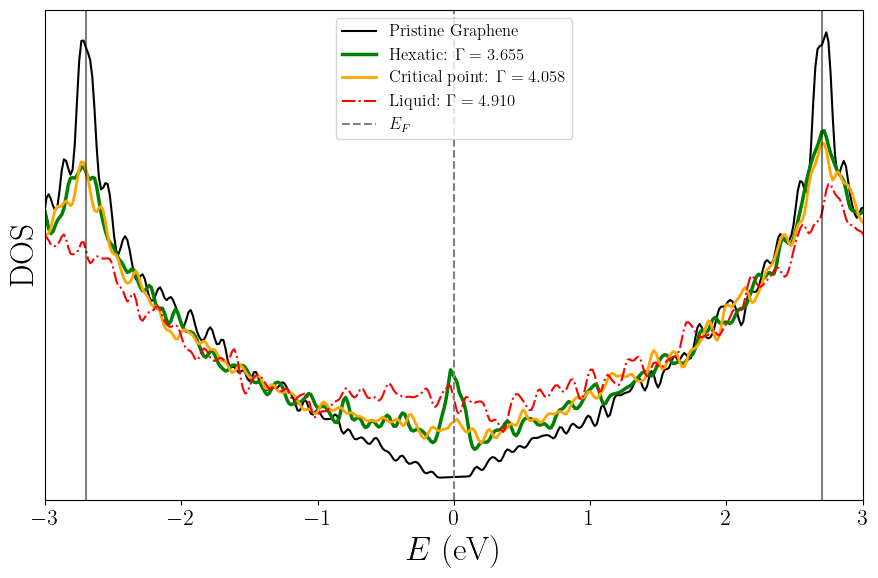